In [ ]:
pip install astropy

In [ ]:
pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
pip install jampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
from scipy import constants
from astropy.convolution import convolve_fft, Gaussian2DKernel
from astropy.io import fits
from astropy.modeling.models import Gaussian1D
from astropy.nddata import block_reduce
from lmfit import Parameters, Minimizer
from jampy import mge_vcirc  # Assuming JamPy is installed and available
import matplotlib.pyplot as plt

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 149200
    # variables        = 9
    chi-square         = 154172.601
    reduced chi-square = 1.03339076
    Akaike info crit   = 4909.53328
    Bayesian info crit = 4998.75067
##  Warning: uncertainties could not be estimated:
    M_BH:        at initial value
    Upsilon_H:   at initial value
    i:           at initial value
    Gamma:       at boundary
    sigma_turb:  at initial value
    z_obs:       at initial value
    F0:          at initial value
[[Variables]]
    M_BH:        1.0000e+08 (init = 1e+08)
    Upsilon_H:   1.00000000 (init = 1)
    x_c:         0.00000000 (init = 0)
    y_c:         0.00000000 (init = 0)
    i:           70.0000000 (init = 70)
    Gamma:       0.00000000 (init = 0)
    sigma_turb: 10.00000000 (init = 10)
    z_obs:       0.00500000 (init = 0.005)
    F0:          1.00000000 (init = 1)


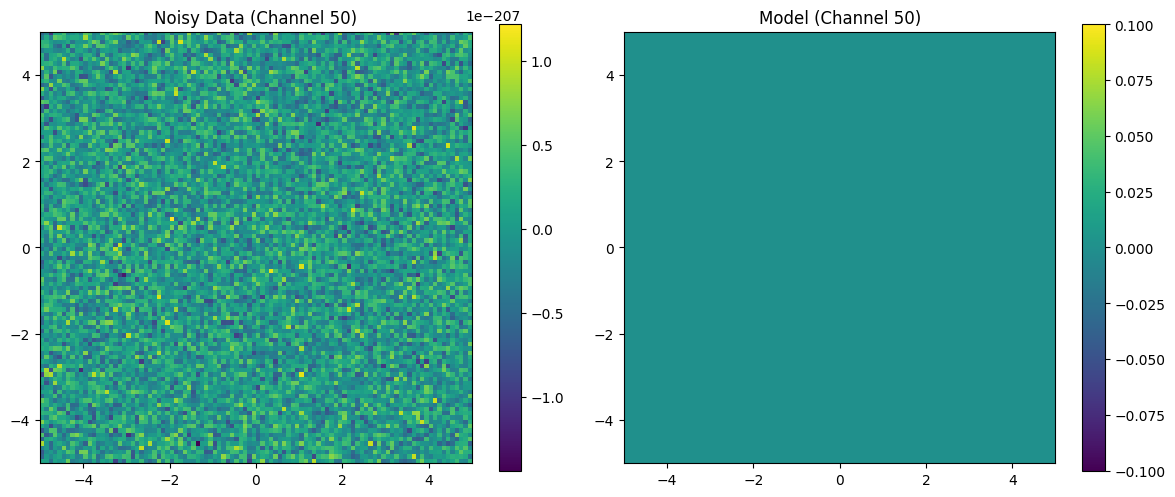

In [ ]:
import numpy as np
from scipy import constants
from astropy.convolution import convolve_fft, Gaussian2DKernel
from astropy.nddata import block_reduce
from lmfit import Parameters, Minimizer, fit_report
import matplotlib.pyplot as plt

# Option 1: If jampy and mge_vcirc are properly installed
# from jampy.mge_vcirc import mge_vcirc  # Correct import

# Option 2: If you can't import mge_vcirc, define a simplified version
def mge_vcirc(surf, sigma, q, inc, radii):
    """
    Simplified calculation of the circular velocity due to the stellar MGE.
    For testing purposes, this function provides a mock-up of the expected behavior.
    """
    # Convert inclination to radians
    inc_rad = np.deg2rad(inc)

    # Compute the cumulative mass profile (simplified)
    # This is not accurate but serves as a placeholder
    total_mass = np.sum(surf * 2 * np.pi * sigma**2 * q)

    # Avoid division by zero
    radii = np.where(radii == 0, 0.1, radii)

    # Compute circular velocity without Upsilon_H
    v_circ = np.sqrt(G * total_mass / radii)

    return v_circ

import matplotlib.pyplot as plt

# Constants
G = 4.30091e-3  # Gravitational constant in pc M_sun^{-1} (km/s)^2

# Define the model parameters (initial guesses)
params = Parameters()
params.add('M_BH', value=1e8, min=1e6, max=1e10)  # Black hole mass in solar masses
params.add('Upsilon_H', value=1.0, min=0.1, max=10.0)  # Stellar M/L ratio
params.add('x_c', value=0.0)  # Disk center x-coordinate (arcsec)
params.add('y_c', value=0.0)  # Disk center y-coordinate (arcsec)
params.add('i', value=70.0, min=0.0, max=90.0)  # Inclination angle (degrees)
params.add('Gamma', value=0.0, min=0.0, max=360.0)  # Position angle (degrees)
params.add('sigma_turb', value=10.0, min=0.0, max=100.0)  # Turbulent velocity dispersion (km/s)
params.add('z_obs', value=0.005, min=0.0, max=1.0)  # Observed redshift
params.add('F0', value=1.0)  # Flux scaling factor

# Other model constants
s = 3  # Oversampling factor
pixel_scale = 0.1  # Original ALMA pixel scale in arcsec/pixel
sub_pixel_scale = pixel_scale / s  # Oversampled pixel scale

# Distance to the galaxy (assuming 20 Mpc for test purposes)
D = 20.0  # Distance in Mpc

# Define the grid
size = 10.0  # Size of the grid in arcsec
n_sub_pixels = int(size / sub_pixel_scale)  # 300
x = np.linspace(-size / 2, size / 2, n_sub_pixels)
y = np.linspace(-size / 2, size / 2, n_sub_pixels)
X, Y = np.meshgrid(x, y)

# Load or define the MGE model parameters (example values)
surf = np.array([1e3, 5e2, 1e2])  # Surface brightness of Gaussians
sigma_mge = np.array([1.0, 2.0, 5.0])  # Widths in arcsec
q = np.array([0.9, 0.8, 0.7])  # Axial ratios

# Load or create the CO flux map (example using a 2D Gaussian)
amplitude = 1.0
x0 = 0.0
y0 = 0.0
sigma_x = 1.0  # arcsec
sigma_y = 1.0  # arcsec
flux_map = amplitude * np.exp(-((X - x0) ** 2 / (2 * sigma_x ** 2) + (Y - y0) ** 2 / (2 * sigma_y ** 2)))

# Define the velocity grid
v_sys = constants.c / 1e3 * params['z_obs'].value  # Systemic velocity in km/s
v_min = v_sys - 300  # km/s
v_max = v_sys + 300  # km/s
N_v = 100  # Number of velocity channels
v_channels = np.linspace(v_min, v_max, N_v)

# Define the ALMA beam parameters
beam_major = 0.5  # arcsec
beam_minor = 0.4  # arcsec
beam_pa = 45.0  # degrees

def compute_model(params, X, Y, v_channels, flux_map):
    # Extract parameters
    M_BH = params['M_BH'].value
    Upsilon_H = params['Upsilon_H'].value
    x_c = params['x_c'].value
    y_c = params['y_c'].value
    i = params['i'].value
    Gamma = params['Gamma'].value
    sigma_turb = params['sigma_turb'].value
    z_obs = params['z_obs'].value
    F0 = params['F0'].value

    # Coordinate transformations
    delta_X = X - x_c
    delta_Y = Y - y_c
    Gamma_rad = np.deg2rad(Gamma)
    i_rad = np.deg2rad(i)
    sin_i = np.sin(i_rad)
    cos_i = np.cos(i_rad)

    # Rotate coordinates to disk frame
    x_prime = delta_X * np.cos(Gamma_rad) + delta_Y * np.sin(Gamma_rad)
    y_prime = -delta_X * np.sin(Gamma_rad) + delta_Y * np.cos(Gamma_rad)

    # Correct y' for inclination
    y_prime_disk = y_prime / cos_i

    # Radius in disk plane
    r_disk = np.sqrt(x_prime ** 2 + y_prime_disk ** 2)
    r_disk = np.where(r_disk == 0, 0.1, r_disk)  # Avoid division by zero

    # Compute circular velocity components
    R_pc = r_disk * D * 1e6 * np.deg2rad(1 / 3600)  # Convert arcsec to pc
    v_BH = np.sqrt(G * M_BH / R_pc)

    # Compute stellar contribution using mge_vcirc
    v_star_MGE = mge_vcirc(surf, sigma_mge, q, inc=i, radii=R_pc.flatten())
    v_star_MGE = v_star_MGE.reshape(X.shape)
    Upsilon_MGE = 1.0  # As per the method description
    v_star = np.sqrt((Upsilon_H / Upsilon_MGE) * v_star_MGE ** 2)

    # Total circular velocity
    v_c = np.sqrt(v_BH ** 2 + v_star ** 2)  # km/s

    # Compute line-of-sight velocities
    v_LOS = v_c * sin_i * (x_prime / r_disk)

    # Create the line profiles
    v_diff = v_channels[np.newaxis, np.newaxis, :] - v_LOS[:, :, np.newaxis]
    sigma_v = sigma_turb  # km/s
    line_profiles = flux_map[:, :, np.newaxis] * np.exp(-v_diff ** 2 / (2 * sigma_v ** 2))
    line_profiles *= F0  # Apply flux scaling factor

    # Downsample the model cube to ALMA pixel scale
    downsampled_cube = block_reduce(line_profiles, block_size=(s, s, 1), func=np.sum)

    # Convolve with ALMA beam
    fwhm_to_sigma = 1.0 / (2 * np.sqrt(2 * np.log(2)))
    sigma_x_arcsec = beam_major * fwhm_to_sigma
    sigma_y_arcsec = beam_minor * fwhm_to_sigma
    sigma_x_pixels = sigma_x_arcsec / pixel_scale
    sigma_y_pixels = sigma_y_arcsec / pixel_scale
    theta_rad = np.deg2rad(beam_pa)
    kernel = Gaussian2DKernel(x_stddev=sigma_x_pixels, y_stddev=sigma_y_pixels, theta=theta_rad)
    kernel.normalize()
    for idx in range(downsampled_cube.shape[2]):
        downsampled_cube[:, :, idx] = convolve_fft(
            downsampled_cube[:, :, idx], kernel, normalize_kernel=True
        )

    return downsampled_cube

def residual(params, X, Y, v_channels, flux_map, data_cube, noise_cube, mask):
    model_cube = compute_model(params, X, Y, v_channels, flux_map)
    # Apply the mask to select fitting regions
    res = ((data_cube - model_cube) / noise_cube)[mask]
    return res.flatten()

# Generate test data using the model with known parameters
true_params = params.copy()
true_params['M_BH'].value = 5e8  # True black hole mass
true_params['Upsilon_H'].value = 2.0  # True M/L ratio
true_params['x_c'].value = 0.1  # Slight offset
true_params['y_c'].value = -0.1  # Slight offset
true_params['i'].value = 75.0  # True inclination
true_params['Gamma'].value = 30.0  # True position angle
true_params['sigma_turb'].value = 20.0  # True turbulent velocity
true_params['z_obs'].value = 0.005  # True redshift
true_params['F0'].value = 1.0  # Flux scaling

# Compute the "observed" data cube
data_cube_true = compute_model(true_params, X, Y, v_channels, flux_map)

# Add noise to the data cube
noise_level = 0.05 * np.max(data_cube_true)  # 5% of the maximum value
noise_cube = noise_level * np.ones_like(data_cube_true)
np.random.seed(42)  # For reproducibility
data_cube_noisy = data_cube_true + np.random.normal(scale=noise_level, size=data_cube_true.shape)

# Create a mask for fitting regions (e.g., where flux is significant)
flux_threshold = 0.1 * np.max(flux_map)
mask_2d = flux_map > flux_threshold  # Shape: (300, 300)

# Downsample the mask to match the downsampled data cube spatial dimensions
# Using block_reduce with func=np.any to preserve any true value within the block
mask_reduced = block_reduce(mask_2d, block_size=(s, s), func=np.any)  # Shape: (100, 100)

# Expand the mask along the velocity axis to match (100, 100, 100)
mask = np.repeat(mask_reduced[:, :, np.newaxis], N_v, axis=2)  # Shape: (100, 100, 100)

# Verify that mask dimensions match data_cube_noisy dimensions
assert mask.shape == data_cube_noisy.shape, f"Mask shape {mask.shape} does not match data_cube shape {data_cube_noisy.shape}"

# Create the Minimizer and optimize
minner = Minimizer(
    residual,
    params,
    fcn_args=(X, Y, v_channels, flux_map, data_cube_noisy, noise_cube, mask)
)
result = minner.minimize()

# Check if minimization was successful before printing the fit report
if result.success:
    print(fit_report(result))
else:
    print("Minimization failed:", result.message)

# Plot the data and model for comparison (example for one channel)
channel = N_v // 2  # Middle channel
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(
    data_cube_noisy[:, :, channel],
    origin='lower',
    cmap='viridis',
    extent=[-size/2, size/2, -size/2, size/2]
)
plt.title(f'Noisy Data (Channel {channel})')
plt.colorbar()

plt.subplot(1, 2, 2)
model_cube = compute_model(result.params, X, Y, v_channels, flux_map)
plt.imshow(
    model_cube[:, :, channel],
    origin='lower',
    cmap='viridis',
    extent=[-size/2, size/2, -size/2, size/2]
)
plt.title(f'Model (Channel {channel})')
plt.colorbar()

plt.tight_layout()
plt.show()